In [37]:
import datetime as dt

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import networkx as nx

In [6]:
bikes_df = pd.read_csv('../dataset/processed/processed_dataset.csv')

### Podstawowe parametry danych

In [11]:
# ile wierszy i kolumn
bikes_df.shape

(4643014, 7)

In [12]:
# jakie kolumny
bikes_df.columns

Index(['uid', 'bike_number', 'start_time', 'end_time', 'rental_place',
       'return_place', 'duration'],
      dtype='object')

In [10]:
bikes_df.head(7)

,uid,bike_number,start_time,end_time,rental_place,return_place,duration
0,111139579,651289,2020-12-29 12:46:41,2021-01-05 13:13:00,al. Brücknera / Kwidzyńska,al. Brücknera / Kwidzyńska,10107
1,111184502,651466,2020-12-31 23:39:21,2021-01-01 00:27:47,Zachodnia / Poznańska,Legnicka / Zachodnia,49
2,111184651,650178,2021-01-01 00:10:09,2021-01-01 00:15:27,Traugutta / Kościuszki,Traugutta / Kościuszki,6
3,111184655,651385,2021-01-01 00:10:42,2021-01-01 00:20:17,Pilczycka / Kozanowska,Drzewieckiego / Dedala,10
4,111184679,651165,2021-01-01 00:15:47,2021-01-01 00:41:10,Kozanowska / Pilczycka,Bezpieczna / Obornicka,26
5,111185059,57595,2021-01-01 01:12:57,2021-01-01 01:35:42,Średzka / Dolnobrzeska,Średzka / Dolnobrzeska,23
6,111185061,650971,2021-01-01 01:13:06,2021-01-01 01:35:33,Średzka / Dolnobrzeska,Średzka / Dolnobrzeska,23


In [ ]:
# zakres czasu
min_time = bikes_df["start_time"].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).min()
max_time = bikes_df["end_time"].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).max()

print(f"Okres uwzględniony w danych:\n{min_time}  -  {max_time}")

In [16]:
# liczba różnych wartości dla rental_place i return_place
print(f'rental_place: {len(set(bikes_df["rental_place"]))} różnych wartości')
print(f'return_place: {len(set(bikes_df["return_place"]))} różnych wartości')
both = len(
    set.union(
        set(bikes_df["rental_place"]),  set(bikes_df["return_place"])
    )
)
print(f'rental_place i return_place wspólnie: {both} różnych wartości')

rental_place: 246 różnych wartości
return_place: 312 różnych wartości
rental_place i return_place wspólnie: 315 różnych wartości


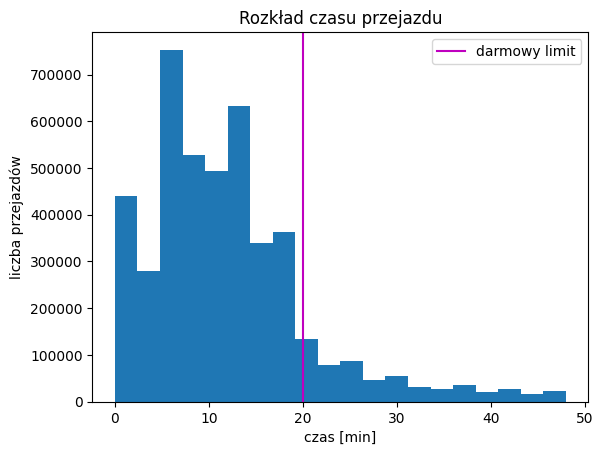

In [31]:
# rozkład czasu przejazdu (bez outlierów)

dur = bikes_df["duration"]
dur_no_outliers = dur[dur < dur.quantile(0.95)]

fig, ax = plt.subplots()
ax.hist(dur_no_outliers, bins=20)
ax.set_title("Rozkład czasu przejazdu")
ax.set_xlabel("czas [min]")
ax.set_ylabel("liczba przejazdów")

# zaznaczamy granicę darmowego przejazdu 20 minut
ax.axvline(ymin=0, ymax=9e5, x=20, c='m', label="darmowy limit")

ax.legend()
plt.show()